Importing necessary libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, r2_score, mean_absolute_error
from sklearn.preprocessing import LabelEncoder
import joblib
import warnings
from datetime import datetime
import os
from pathlib import Path

Loading the data

In [3]:
df =pd.read_csv('/home/margaret/Capstone-Project/CleanWatAI/data/processed/gems.csv')
df.head()

,GEMS.Station.Number_Sample.Date,pH,NO2N,NO3N,TP,O2-Dis,NH4N,TEMP,EC
0,AUT00009_2021-02-01,8.0,0.002003,0.623578,0.008,12.7,0.004000,2.5,180.0
1,AUT00009_2021-03-01,8.1,0.002003,0.666549,0.010,13.5,0.004000,1.0,148.0
2,AUT00009_2021-04-06,8.0,0.002003,0.599595,0.007,12.3,0.006001,2.9,140.0
3,AUT00009_2021-05-03,8.0,0.002003,0.517650,0.018,12.3,0.006001,4.2,99.0
4,AUT00009_2021-06-01,7.8,0.002003,0.258825,0.021,11.7,0.005001,5.6,101.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36277 entries, 0 to 36276
Data columns (total 9 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   GEMS.Station.Number_Sample.Date  36277 non-null  object 
 1   pH                               36277 non-null  float64
 2   NO2N                             36277 non-null  float64
 3   NO3N                             36277 non-null  float64
 4   TP                               36277 non-null  float64
 5   O2-Dis                           36277 non-null  float64
 6   NH4N                             36277 non-null  float64
 7   TEMP                             36277 non-null  float64
 8   EC                               36277 non-null  float64
dtypes: float64(8), object(1)
memory usage: 2.5+ MB


In [5]:
df.describe()

,pH,NO2N,NO3N,TP,O2-Dis,NH4N,TEMP,EC
count,36277.000000,36277.000000,36277.000000,36277.000000,36277.000000,36277.000000,36277.000000,36277.000000
mean,7.921824,0.063312,1.402023,0.162517,8.561560,0.350331,17.755771,632.158585
std,0.538388,0.409187,3.224877,0.596616,3.577237,1.917548,9.496721,1267.151904
min,2.280000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.140000
25%,7.700000,0.003004,0.200000,0.010000,6.940000,0.020000,10.900000,250.500000
50%,8.000000,0.006000,0.509655,0.039500,8.400000,0.040000,17.400000,410.000000
75%,8.280000,0.040000,1.500002,0.150000,10.300000,0.120000,25.000000,665.000000
max,11.000000,40.033982,145.080000,66.000000,141.200000,51.000000,265.000000,43300.000000


In [6]:
df.shape

(36277, 9)

In [7]:
features = ['pH', 'NO2N', 'NO3N', 'TP', 'O2-Dis', 'NH4N', 'TEMP', 'EC']


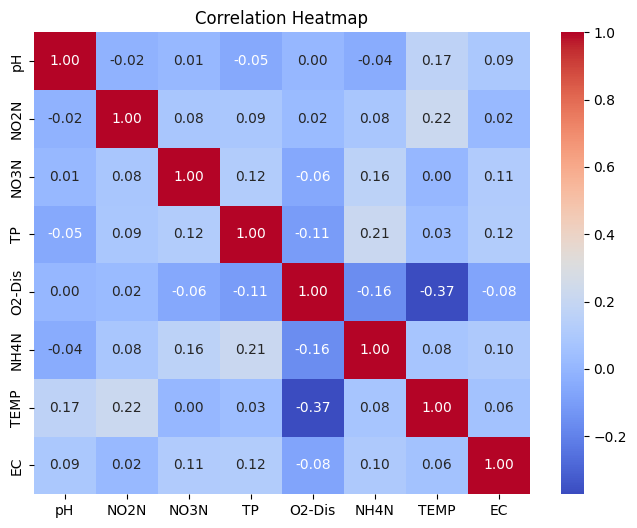

In [8]:
plt.figure(figsize=(8, 6))
sns.heatmap(df[features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


In [9]:

# Split 'GEMS.Station.Number_Sample.Date' into 'station_id' and 'sample_date'
df[['station_id', 'sample_date']] = df['GEMS.Station.Number_Sample.Date'].str.split('_', expand=True)
df['sample_date'] = pd.to_datetime(df['sample_date'], errors='coerce')
df['year'] = df['sample_date'].dt.year
df['month'] = df['sample_date'].dt.month
df['day_of_year'] = df['sample_date'].dt.dayofyear

# Encode station ID
le = LabelEncoder()
df['station_encoded'] = le.fit_transform(df['station_id'].fillna('UNKNOWN'))

# Drop missing values in required columns
required = ['pH', 'TEMP', 'EC', 'NO2N', 'NO3N', 'O2-Dis', 'NH4N']
df = df.dropna(subset=required)


In [10]:
df['pH_bin'] = pd.cut(df['pH'], bins=5, labels=False)
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in split.split(df, df['pH_bin']):
    train_df = df.iloc[train_idx].copy()
    test_df = df.iloc[test_idx].copy()


In [11]:
features = ['pH', 'TEMP', 'EC', 'year', 'month', 'day_of_year', 'station_encoded']
targets = ['NO2N', 'NO3N', 'O2-Dis', 'NH4N']
virtual_lab_models = {}

for target in targets:
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(train_df[features], train_df[target])
    virtual_lab_models[target] = model


In [12]:
def calc_wqi(sample):
    score = 0
    score += 0.2 * (100 if 6.5 <= sample['pH'] <= 8.5 else 0)
    score += 0.15 * (100 if sample['NO2N'] <= 3 else 0)
    score += 0.2 * (100 if sample['NO3N'] <= 50 else 0)
    score += 0.15 * (100 if sample['O2-Dis'] >= 5 else 0)
    score += 0.15 * (100 if sample['NH4N'] <= 1.5 else 0)
    return score

def classify(score):
    if score >= 70: return 'Safe'
    elif score >= 50: return 'Caution'
    else: return 'Unsafe'

def get_labels(df, models):
    preds = pd.DataFrame(index=df.index)
    for target in targets:
        preds[target] = models[target].predict(df[features])
    preds['pH'] = df['pH']
    return preds.apply(lambda row: classify(calc_wqi(row)), axis=1)

y_train = get_labels(train_df, virtual_lab_models)
y_test = get_labels(test_df, {t: virtual_lab_models[t] for t in targets})


In [ ]:

# Define  features
features = ['pH', 'TEMP', 'EC', 'year', 'month', 'day_of_year', 'station_encoded']

# Train the classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(train_df[features], y_train)

# Predict on test data
y_pred = clf.predict(test_df[features])

In [ ]:
print("Classification Report:\n", classification_report(y_test, y_pred))


In [ ]:
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Unsafe', 'Safe'], yticklabels=['Unsafe', 'Safe'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [13]:
df[['Station', 'Date']] = df['GEMS.Station.Number_Sample.Date'].str.split('_', expand=True)
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Extract time components
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['day_of_year'] = df['Date'].dt.dayofyear

# Sort for clean plotting
df = df.sort_values(by='Date')

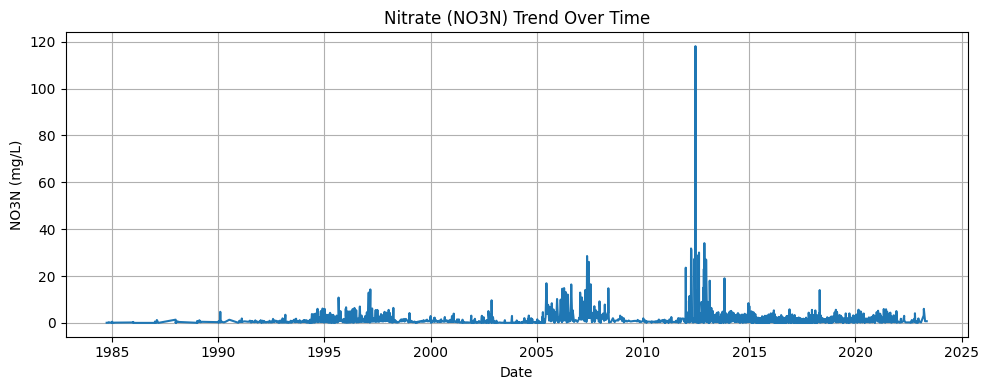

In [19]:
plt.figure(figsize=(10, 4))
sns.lineplot(data=df, x='Date', y='NO3N', errorbar=None)
plt.title('Nitrate (NO3N) Trend Over Time')
plt.ylabel('NO3N (mg/L)')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()
plt.show()

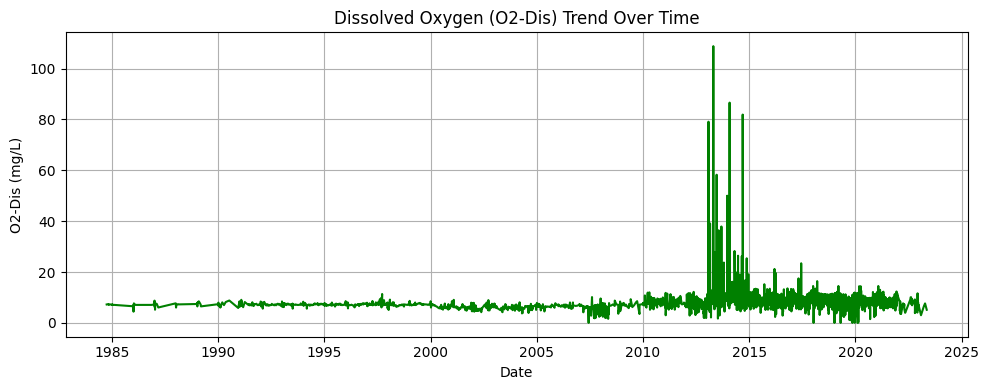

In [18]:
# Plot 2: O2-Dis over time
plt.figure(figsize=(10, 4))
sns.lineplot(data=df, x='Date', y='O2-Dis', errorbar=None, color='green')
plt.title('Dissolved Oxygen (O2-Dis) Trend Over Time')
plt.ylabel('O2-Dis (mg/L)')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()
plt.show()

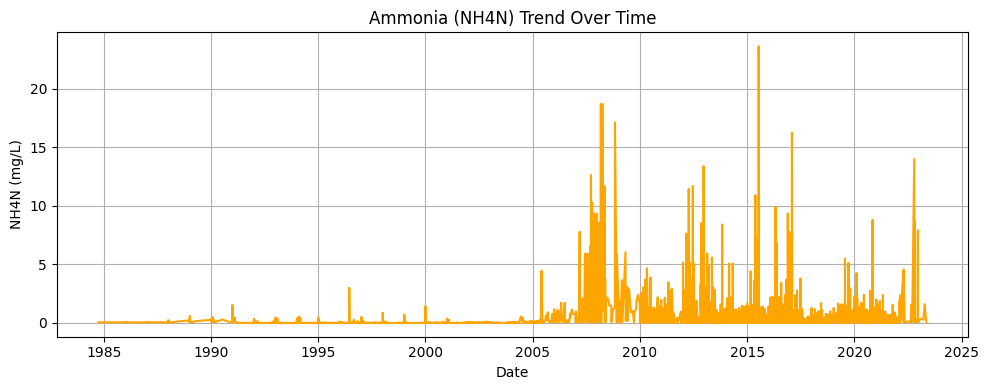

In [20]:
plt.figure(figsize=(10, 4))
sns.lineplot(data=df, x='Date', y='NH4N', errorbar=None, color='orange')
plt.title('Ammonia (NH4N) Trend Over Time')
plt.ylabel('NH4N (mg/L)')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()
plt.show()